In [1]:
!pip install tensorflow==2.0.0-rc1

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential, model_from_json
from keras.utils import to_categorical
from keras.layers.core import Dense, Dropout, Flatten
from keras.optimizers import RMSprop
from keras.layers.convolutional import Conv2D
from keras.callbacks import ModelCheckpoint
from keras.layers import Embedding, TimeDistributed, RepeatVector, LSTM, concatenate , Input, Reshape, Dense
from keras.preprocessing.image import array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [3]:
tf.__version__

'2.0.0-rc1'

In [4]:
!wget https://www.floydhub.com/api/v1/download/artifacts/data/tPpZtZD79p2AvcT8P39VVA?is_dir=true&path=train -O dataset.tar

/bin/bash: -O: command not found
--2019-09-25 20:21:49--  https://www.floydhub.com/api/v1/download/artifacts/data/tPpZtZD79p2AvcT8P39VVA?is_dir=true
Resolving www.floydhub.com (www.floydhub.com)... 104.25.128.32, 104.25.129.32, 2606:4700:20::6819:8020, ...
Connecting to www.floydhub.com (www.floydhub.com)|104.25.128.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘tPpZtZD79p2AvcT8P39VVA?is_dir=true’

p2AvcT8P39VVA?is_di     [    <=>             ] 517.77M  35.2MB/s               

KeyboardInterrupt: ignored

In [0]:
!mv tPpZtZD79p2AvcT8P39VVA?is_dir=true dataset.tar

In [0]:
!tar -xvf dataset.tar

In [5]:
os.listdir('train')

['24E540D8-9D42-46B6-8FD9-BB4442A3C9E8.npz',
 'D6BDC2ED-B2C3-455B-8DD3-74ABD643C461.gui',
 '9B7FA9BC-2B10-48DF-B181-43C6EE268A96.gui',
 '18533A43-8768-4436-84F3-8F53AE95B508.gui',
 '16C57A8E-E2AD-49D7-B85F-40BE6245A243.npz',
 '85F07346-C058-44F2-9E7D-A9809988DB47.gui',
 'DF9069B1-496D-4694-853C-BA5582679726.gui',
 'F632DF45-4EC4-4542-BC37-A1E9532528E3.gui',
 '262AF449-BF51-4E67-936D-78CE2CEC7467.gui',
 '578BE21B-B784-42F9-9DC5-EAB79F31B53D.gui',
 'A933808A-F713-4639-B599-C8E17A6510F1.gui',
 'C9DC9CE1-1F88-4028-AF93-09877422FEF7.gui',
 '9D8069D1-C0BA-428B-8454-7CDBA626659B.npz',
 '06FEF995-3AC3-4ECC-8143-53A3167EB2B5.gui',
 'D02AF11F-6037-4D6E-B460-B70B61B4A19D.gui',
 '56B1A217-27E8-43D2-9485-EF4D6D97C995.npz',
 'DA6EA8A3-A744-4D04-AD80-3A405B73A7D1.npz',
 '5733B056-29D7-415D-954E-441D5D592F75.npz',
 '5BBF2621-26A6-4998-8C77-67049AB95FE1.gui',
 '0529E00F-15B6-43BD-86FB-F15245861B07.gui',
 '25833168-8453-4B2A-9E3B-E8E818C2AFE7.gui',
 'D745C87A-EE39-4FFC-AE5B-22954B947080.gui',
 '43B0FA9E

In [0]:
def load_data(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

def load_dataset(data_dir):
    text = []
    images = []
    filenames = os.listdir(data_dir)
    filenames.sort()
    for filename in filenames:
        if filename[-3:] == "npz":
            image = np.load(data_dir+'/'+filename)
            images.append(image['features'])
        else:
            syntax = '<START> ' + load_data(data_dir+'/'+filename) + ' <END>'
            syntax = ' '.join(syntax.split())
            syntax = syntax.replace(',', ' ,')
            text.append(syntax)
    images = np.array(images, dtype=float)
    return images, text

In [0]:
def show_img(im, figsize=None):
    fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [0]:
train_data, code = load_dataset('train')

In [9]:
train_data.shape

(1500, 256, 256, 3)

Bootstrap code: <START> header { btn-inactive , btn-inactive , btn-inactive , btn-active } row { single { small-title , text , btn-red } } row { quadruple { small-title , text , btn-green } quadruple { small-title , text , btn-orange } quadruple { small-title , text , btn-red } quadruple { small-title , text , btn-orange } } row { double { small-title , text , btn-red } double { small-title , text , btn-orange } } <END>


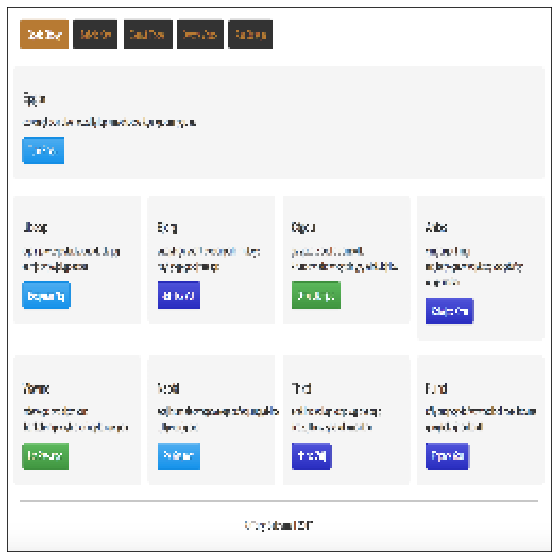

In [12]:
print("Bootstrap code:", code[0])
ax = show_img(train_data[1], figsize=(10,10))

In [0]:
bootstrap_vocab = ', { } small-title text quadruple row btn-inactive btn-red btn-green btn-orange double <START> header btn-active <END> single'

In [0]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='' , split=" " , lower=False)
tokenizer.fit_on_texts([bootstrap_vocab])

In [15]:
tokenizer.word_index

{',': 1,
 '<END>': 16,
 '<START>': 13,
 'btn-active': 15,
 'btn-green': 10,
 'btn-inactive': 8,
 'btn-orange': 11,
 'btn-red': 9,
 'double': 12,
 'header': 14,
 'quadruple': 6,
 'row': 7,
 'single': 17,
 'small-title': 4,
 'text': 5,
 '{': 2,
 '}': 3}

In [0]:
vocab_size = len(tokenizer.word_index) + 1

In [17]:
vocab_size

18

In [0]:
MAX_SEQUENCE = 150
MAX_LEN = 48 

In [0]:
def preprocess_data(texts, features):
    X = []
    y = []
    image_data = []
    sequences = tokenizer.texts_to_sequences(texts)
    max_sequence = max(len(s) for s in sequences)
    for img_no, seq in enumerate(sequences):
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = tf.keras.preprocessing.sequence.pad_sequences([in_seq], maxlen=max_sequence)[0]
            out_seq = tf.keras.utils.to_categorical([out_seq], num_classes=vocab_size)[0]
            image_data.append(features[img_no])
            X.append(in_seq[-MAX_LEN:])
            y.append(out_seq)
    return np.array(image_data), np.array(X), np.array(y) , max_sequence

In [0]:
train_data , X , y , MAX_SEQUENCE = preprocess_data(code , train_data)

In [0]:
def data_generator(descriptions, features, n_step, max_sequence):
    while 1:
        for i in range(0, len(descriptions), n_step):
            X_images = []
            X_seq = []
            y = []
            for j in range(i, min(len(descriptions), i+n_step)):
                image = features[j]
                desc = descriptions[j]
                in_img, in_seq, out_word = preprocess_data([desc], [image], max_sequence)
                for k in range(len(in_img)):
                    X_images.append(in_img[k])
                    X_seq.append(in_seq[k])
                    y.append(out_word[k])
            yield [[np.array(X_images), np.array(X_seq)], np.array(y)]

In [0]:
image_model = tf.keras.models.Sequential()
image_model.add(tf.keras.layers.Conv2D(16 , (3 , 3) , padding='valid' , activation='relu' , input_shape=(256 , 256 , 3)))
image_model.add(tf.keras.layers.Conv2D(16 , (3 , 3) , activation='relu' , padding='same' , strides=2))
image_model.add(tf.keras.layers.Conv2D(32 , (3 , 3) , activation='relu' , padding='same'))
image_model.add(tf.keras.layers.Conv2D(32 , (3 , 3) , activation='relu' , padding='same' , strides=2))
image_model.add(tf.keras.layers.Conv2D(64 , (3 , 3) , activation='relu' , padding='same'))
image_model.add(tf.keras.layers.Conv2D(64 , (3 , 3) , activation='relu' , padding='same' , strides=2))
image_model.add(tf.keras.layers.Conv2D(128 , (3 , 3) , activation='relu' , padding='same'))
image_model.add(tf.keras.layers.Flatten())
image_model.add(tf.keras.layers.Dense(1024 , activation='relu'))
image_model.add(tf.keras.layers.Dropout(0.3))
image_model.add(tf.keras.layers.Dense(1024 , activation='relu'))
image_model.add(tf.keras.layers.Dropout(0.3))
image_model.add(tf.keras.layers.RepeatVector(MAX_LEN))

input_image = tf.keras.layers.Input(shape=(256 , 256 , 3))
encoded_image = image_model(input_image)

In [24]:
code_input = tf.keras.layers.Input(shape=(MAX_LEN , ))
code_model = tf.keras.layers.Embedding(vocab_size , 50 , input_length=MAX_LEN , mask_zero=True)(code_input)
code_model = tf.keras.layers.LSTM(128 , return_sequences=True)(code_model)
code_model = tf.keras.layers.LSTM(128 , return_sequences=True)(code_model)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
decoder = tf.keras.layers.concatenate([encoded_image , code_model])
decoder = tf.keras.layers.LSTM(512 , return_sequences=True)(decoder)
decoder = tf.keras.layers.LSTM(512 , return_sequences=False)(decoder)
decoder = tf.keras.layers.Dense(vocab_size , activation='softmax')(decoder)

In [0]:
model = tf.keras.Model(inputs=[input_image , code_input] , outputs=decoder)

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 48)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 48, 50)       900         input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 48, 128)      91648       embedding[0][0]                  
______________________________________________________________________________________________

In [29]:
image_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 127, 127, 16)      2320      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 127, 127, 32)      4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 128)      

In [30]:
filepath="model/org-weights-epoch-{epoch:04d}--loss-{loss:.4f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, verbose=1, save_weights_only=True, period=2)
callbacks_list = [checkpoint]

optimizer = tf.keras.optimizers.RMSprop(lr=0.0001, clipvalue=1.0)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [0]:
X, y, image_data = preprocess_data(train_sequences, train_features)

In [71]:
model.fit_generator(data_generator(code, train_data, 1, MAX_SEQUENCE), 
                    steps_per_epoch=1500, 
                    epochs=50, 
                    callbacks=callbacks_list, 
                    verbose=2)

Epoch 1/50


ValueError: ignored